## Remove test and validation spectra
Validation and test spectra are removed. These spectra will not be used for training the models. 

Two test sets are created:
All spectra belonging to inchikeys not in training spectra.
Random spectra for which there is still at least one inchikey in the dataset.



In [1]:
import pickle
import os
path_data = "C:\\HSD\\OneDrive - Hochschule Düsseldorf\\Data\\ms2query"

In [2]:
file_data = os.path.join(path_data, "ALL_GNPS_15_12_2021_positive_annotated.pickle")
with open(file_data, 'rb') as file:
    positive_fully_annotated = pickle.load(file)

In [3]:
import numpy as np
np.random.seed(4321)

def select_unique_inchikeys(spectra):
    inchikey_list = []
    for spectrum in spectra:
        inchikey = spectrum.get("inchikey")[:14]
        inchikey_list.append(inchikey)
    inchikey_set = set(inchikey_list)
    print(len(inchikey_list))
    print(len(inchikey_set))
    return sorted(list(inchikey_set))

    
def split_into_train_and_val(inchikey_list):
    n_spectra = len(inchikey_list)
    n_val = 250
    n_test = 250
    n_train = n_spectra - n_val - n_test
    print("Split dataset into train/val/test fractions:", n_train, n_val, n_test)
    
    inchikey_ids = np.arange(n_spectra)
    # Select training, validation, and test IDs:
    train_inchikeyIDs = np.random.choice(inchikey_ids, n_train, replace=False)
    val_inchikeyIDs = np.random.choice(list(set(inchikey_ids) - set(train_inchikeyIDs)), n_val, replace=False)
    test_inchikeyIDs = list(set(inchikey_ids) - set(train_inchikeyIDs) - set(val_inchikeyIDs))
    train_split = [inchikey_list[i] for i in train_inchikeyIDs]
    val_split = [inchikey_list[i] for i in val_inchikeyIDs]
    test_split = [inchikey_list[i] for i in test_inchikeyIDs]
    
    return train_split, val_split, test_split 
    
def select_spectra_with_inchikey(inchikeys, spectra):
    selected_spectra = []
    for spectrum in spectra:
        inchikey = spectrum.get("inchikey")[:14]
        if inchikey in inchikeys:
            selected_spectra.append(spectrum)
    return selected_spectra

In [4]:
# For positive mode
np.random.seed(4321)

inchikeys = select_unique_inchikeys(positive_fully_annotated)
train_inchikey, val_inchikey, test_inchikey = split_into_train_and_val(inchikeys)

print(val_inchikey[:10])
print(test_inchikey[:10])

314318
20889
Split dataset into train/val/test fractions: 20389 250 250
['UMGQLEXNQCHIFN', 'JFIXKFSJCQNGEK', 'XZPNBJLXZMBECP', 'CLSKRRFGIZCINS', 'DTBIJJWMZYAFJH', 'KNMJILKSMXODBE', 'METLQVFFFUYXNT', 'GZAGPTKCDQNILD', 'HMODSEUUTCJCOO', 'YTLAPZFYPTVKJL']
['FSBUXLDOLNLABB', 'VYGQXRZAHIZHQV', 'YJQCOFNZVFGCAF', 'WPHXDIQHDVJFHP', 'RAFGELQLHMBRHD', 'NKDJNEGDJVXHKM', 'RALTUMFCLLNZRF', 'OPVAJFQBSDUNQA', 'CYOYVDVFHOPVJH', 'MFUPLJQNEXUUDW']


In [5]:
val_split = select_spectra_with_inchikey(val_inchikey, positive_fully_annotated)
print(len(val_split))
test_split = select_spectra_with_inchikey(test_inchikey, positive_fully_annotated)
print(len(test_split))
train_split = select_spectra_with_inchikey(train_inchikey, positive_fully_annotated)
print(len(train_split))

2817
2987
308514


In [6]:
pickle.dump(val_split,
           open(os.path.join(path_data, "GNPS_15_12_2021_pos_val_250_inchikeys.pickle"), "wb"))
pickle.dump(test_split,
           open(os.path.join(path_data, "GNPS_15_12_2021_pos_test_250_inchikeys.pickle"), "wb"))
pickle.dump(train_split,
           open(os.path.join(path_data, "GNPS_15_12_2021_pos_train_without_250_inchikeys.pickle"), "wb"))

### Plot number of spectra per inchikey

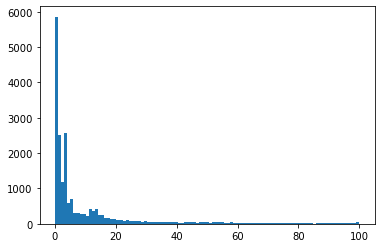

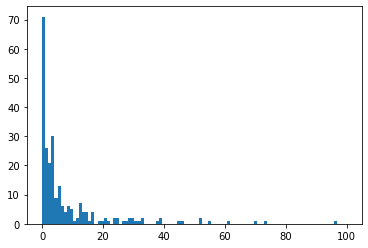

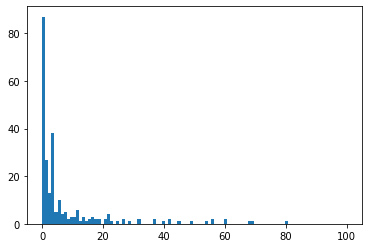

In [7]:
from matplotlib import pyplot as plt

def plot_nr_of_spec_per_inchi(spectra):
    inchikey_dict = {}
    for spectrum in spectra:
        inchikey = spectrum.get("inchikey")[:14]
        if inchikey in inchikey_dict:
            inchikey_dict[inchikey] += 1
        else: 
            inchikey_dict[inchikey] = 1
    plt.hist(list(inchikey_dict.values()), np.linspace(0,100,100))
    plt.show()


plot_nr_of_spec_per_inchi(train_split)
plot_nr_of_spec_per_inchi(val_split)
plot_nr_of_spec_per_inchi(test_split)

## Select 2000 random spectra with multiple inchikeys
Random spectra with multiple inchikeys

In [8]:
import numpy as np
from tqdm.notebook import tqdm
# select inchikeys with more than 1 spectrum
def select_inchikeys_with_multiple_spectra(spectra):
    inchikey_dict = {}
    for i, spectrum in enumerate(spectra):
        inchikey = spectrum.get("inchikey")[:14]
        if inchikey in inchikey_dict:
            inchikey_dict[inchikey].append(i)
        else: 
            inchikey_dict[inchikey] = [i]
    inchikey_with_multiple_spectra = []
    for inchikey in inchikey_dict:
        if len(inchikey_dict[inchikey]) > 1:
            inchikey_with_multiple_spectra.append(inchikey)
    return inchikey_with_multiple_spectra, inchikey_dict

def select_6000_random_spectra_ids(inchikey_with_multiple_spectra, inchikey_dict):
    np.random.seed(123)
    selected_spectrum_ids = []
    selected_inchikeys = np.random.choice(inchikey_with_multiple_spectra, 6000, replace=False)
    for inchikey in selected_inchikeys:
        possible_spectrum_ids = inchikey_dict[inchikey]
        selected_spectrum_id = np.random.choice(possible_spectrum_ids, 1, replace=False)[0]
        selected_spectrum_ids.append(selected_spectrum_id)
    return selected_spectrum_ids

def select_spectra_on_spectrum_id(spectrum_ids, spectra):
    val_spectra = []
    test_spectra = []
    train_spectra =[]
    for i, spectrum in enumerate(tqdm(spectra)):
        if i in spectrum_ids[:3000]:
            val_spectra.append(spectrum)
        elif i in spectrum_ids[3000:]:
            test_spectra.append(spectrum)
        else:
            train_spectra.append(spectrum)
    return val_spectra, test_spectra, train_spectra


In [9]:
outfile = os.path.join(path_data, "GNPS_15_12_2021_pos_train_without_250_inchikeys.pickle")
with open(outfile, 'rb') as file:
    train_split = pickle.load(file)
print(len(train_split))

308514


In [10]:
inchikey_with_multiple_spectra, inchikey_dict = select_inchikeys_with_multiple_spectra(train_split)
print(len(inchikey_with_multiple_spectra))
selected_spectrum_ids = select_6000_random_spectra_ids(inchikey_with_multiple_spectra, inchikey_dict)
print(len(selected_spectrum_ids))
val_spectra, test_spectra, train_spectra = select_spectra_on_spectrum_id(selected_spectrum_ids, train_split)

14528
6000


  0%|          | 0/308514 [00:00<?, ?it/s]

In [11]:
pickle.dump(val_spectra,
           open(os.path.join(path_data, "GNPS_15_12_2021_pos_val_3000_spectra.pickle"), "wb"))
pickle.dump(test_spectra,
           open(os.path.join(path_data, "GNPS_15_12_2021_pos_test_3000_spectra.pickle"), "wb"))
pickle.dump(train_spectra,
           open(os.path.join(path_data, "GNPS_15_12_2021_pos_train.pickle"), "wb"))

In [12]:
print(len(val_spectra))
print(len(test_spectra))
print(len(train_spectra))

3000
3000
302514


In [13]:
# test if they are all unique inchikeys
inchikeys_test = [spectrum.get("inchikey")[:14] for spectrum in test_spectra]
inchikeys_val = [spectrum.get("inchikey")[:14] for spectrum in val_spectra]
inchikeys_train = set([spectrum.get("inchikey")[:14] for spectrum in train_spectra])
print(len(set(inchikeys_test)))
print(len(set(inchikeys_val)))
print(len(inchikeys_train))

for inchikey in inchikeys_test:
    if inchikey not in inchikeys_train:
        print(inchikey)
for inchikey in inchikeys_val:
    if inchikey not in inchikeys_train:
        print(inchikey)

3000
3000
20389


# Analyze data

In [15]:
def count_annotations(spectra):
    inchi_lst = []
    smiles_lst = []
    inchikey_lst = []
    for i, spec in enumerate(spectra):
        inchi_lst.append(spec.get("inchi"))
        smiles_lst.append(spec.get("smiles"))
        inchikey = spec.get("inchikey")
        if inchikey is None:
            inchikey = spec.get("inchikey_inchi")
        inchikey_lst.append(inchikey)

    inchi_count = sum([1 for x in inchi_lst if x])
    smiles_count = sum([1 for x in smiles_lst if x])
    inchikey_count = sum([1 for x in inchikey_lst if x])
    print("nr_of_spectra:", len(spectra))
    print("Inchis:", inchi_count, "--", len(set(inchi_lst)), "unique")
    print("Smiles:", smiles_count, "--", len(set(smiles_lst)), "unique")
    print("Inchikeys:", inchikey_count, "--", 
          len(set([x[:14] for x in inchikey_lst if x])), "unique (first 14 characters)")

In [16]:
outfile = os.path.join(path_data, "ALL_GNPS_15_12_2021_positive_annotated.pickle")
with open(outfile, 'rb') as file:
    positive_fully_annotated = pickle.load(file)
    


In [16]:
count_annotations(positive_fully_annotated)

nr_of_spectra: 314318
Inchis: 314318 -- 24864 unique
Smiles: 314318 -- 32591 unique
Inchikeys: 314318 -- 20889 unique (first 14 characters)


In [18]:
outfile = os.path.join(path_data, "GNPS_15_12_2021_pos_val_250_inchikeys.pickle")
with open(outfile, 'rb') as file:
    val_spectra_250 = pickle.load(file)
    
outfile = os.path.join(path_data, "GNPS_15_12_2021_pos_test_250_inchikeys.pickle")
with open(outfile, 'rb') as file:
    test_spectra_250 = pickle.load(file)

In [18]:
count_annotations(val_split)

nr_of_spectra: 2817
Inchis: 2817 -- 306 unique
Smiles: 2817 -- 364 unique
Inchikeys: 2817 -- 250 unique (first 14 characters)


In [19]:
count_annotations(test_split)

nr_of_spectra: 2987
Inchis: 2987 -- 276 unique
Smiles: 2987 -- 346 unique
Inchikeys: 2987 -- 250 unique (first 14 characters)


In [20]:
outfile = os.path.join(path_data, "GNPS_15_12_2021_pos_val_3000_spectra.pickle")
with open(outfile, 'rb') as file:
    val_spectra_3000 = pickle.load(file)
    
outfile = os.path.join(path_data, "GNPS_15_12_2021_pos_test_3000_spectra.pickle")
with open(outfile, 'rb') as file:
    test_spectra_3000 = pickle.load(file)

outfile = os.path.join(path_data, "GNPS_15_12_2021_pos_train.pickle")
with open(outfile, 'rb') as file:
    train_spectra = pickle.load(file)

In [21]:
count_annotations(val_spectra_3000)

nr_of_spectra: 3000
Inchis: 3000 -- 3000 unique
Smiles: 3000 -- 3000 unique
Inchikeys: 3000 -- 3000 unique (first 14 characters)


In [22]:
count_annotations(test_spectra_3000)

nr_of_spectra: 3000
Inchis: 3000 -- 3000 unique
Smiles: 3000 -- 3000 unique
Inchikeys: 3000 -- 3000 unique (first 14 characters)


In [23]:
count_annotations(train_spectra)

nr_of_spectra: 302514
Inchis: 302514 -- 24139 unique
Smiles: 302514 -- 31547 unique
Inchikeys: 302514 -- 20389 unique (first 14 characters)
